## Install TensorTrade

In [24]:
#!python3 -m pip install git+https://github.com/tensortrade-org/tensortrade.git
!pip install quantstats
!pip install feature_engine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.2/205.2 KB 3.0 MB/s eta 0:00:00a 0:00:01


## Define global variables

In [1]:
n_steps = 1000
n_episodes = 20
window_size = 30
memory_capacity = n_steps * 10
save_path = 'agents/'
n_bins = 5             # Number of bins to partition the dataset evenly in order to evaluate class sparsity.
seed = 1337

## Setup Data Fetching

In [1]:
from tensortrade.data.cdd import CryptoDataDownload

import numpy as np
import pandas as pd
pd.options.mode.use_inf_as_na = True

def prepare_data(df):
    df['volume'] = np.int64(df['volume'])
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values(by='date', ascending=True, inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['date'] = df['date'].dt.strftime('%Y-%m-%d %I:%M %p')
    return df

def fetch_data():
    cdd = CryptoDataDownload()
    bitfinex_data = cdd.fetch("Bitfinex", "USD", "BTC", "1h")
    bitfinex_data = bitfinex_data[['date', 'open', 'high', 'low', 'close', 'volume']]
    bitfinex_data = prepare_data(bitfinex_data)
    return bitfinex_data

def load_csv(filename):
    df = pd.read_csv('data/' + filename, skiprows=1)
    df.drop(columns=['symbol', 'volume_btc'], inplace=True)

    # Fix timestamp from "2019-10-17 09-AM" to "2019-10-17 09-00-00 AM"
    df['date'] = df['date'].str[:14] + '00-00 ' + df['date'].str[-2:]

    return prepare_data(df)

In [2]:
data = fetch_data()
data

date          open          high           low  \
0      2018-05-15 06:00 AM   8723.800000   8793.000000   8714.900000   
1      2018-05-15 07:00 AM   8739.000000   8754.800000   8719.300000   
2      2018-05-15 08:00 AM   8743.000000   8743.100000   8653.200000   
3      2018-05-15 09:00 AM   8723.700000   8737.800000   8701.200000   
4      2018-05-15 10:00 AM   8708.100000   8855.700000   8695.800000   
...                    ...           ...           ...           ...   
34234  2022-04-10 09:00 PM  43128.000000  43223.000000  42626.000000   
34235  2022-04-10 10:00 PM  42711.000000  42745.693560  41933.000000   
34236  2022-04-10 11:00 PM  42147.547378  42433.000000  42031.000000   
34237  2022-04-11 12:00 AM  42181.000000  42404.000000  41824.000000   
34238  2022-04-11 01:00 AM  42330.000000  42385.882659  42304.215719   

              close    volume  
0       8739.000000   8988053  
1       8743.000000   2288904  
2       8723.700000   8891773  
3       8708.100000   2054868  
4       8784.400000  17309722  
...             ...       ...  
34234  42722.000000  17469719  
34235  42170.000000  19196439  
34236  42177.515051   7187135  
34237  42328.000000  16677839  
34238  42355.072427    179889  

[34239 rows x 6 columns]

## Create features for the feed module

In [4]:
import os
import numpy as np
import ta as ta1
import pandas_ta as ta

import quantstats as qs
qs.extend_pandas()

def fix_dataset_inconsistencies(dataframe, fill_value=None):
    dataframe = dataframe.replace([-np.inf, np.inf], np.nan)

    # This is done to avoid filling middle holes with backfilling.
    if fill_value is None:
        dataframe.iloc[0,:] = \
            dataframe.apply(lambda column: column.iloc[column.first_valid_index()], axis='index')
    else:
        dataframe.iloc[0,:] = \
            dataframe.iloc[0,:].fillna(fill_value)

    return dataframe.fillna(axis='index', method='pad').dropna(axis='columns')

def rsi(price: 'pd.Series[pd.Float64Dtype]', period: float) -> 'pd.Series[pd.Float64Dtype]':
    r = price.diff()
    upside = np.minimum(r, 0).abs()
    downside = np.maximum(r, 0).abs()
    rs = upside.ewm(alpha=1 / period).mean() / downside.ewm(alpha=1 / period).mean()
    return 100*(1 - (1 + rs) ** -1)

def macd(price: 'pd.Series[pd.Float64Dtype]', fast: float, slow: float, signal: float) -> 'pd.Series[pd.Float64Dtype]':
    fm = price.ewm(span=fast, adjust=False).mean()
    sm = price.ewm(span=slow, adjust=False).mean()
    md = fm - sm
    signal = md - md.ewm(span=signal, adjust=False).mean()
    return signal

def generate_all_default_quantstats_features(data):
    excluded_indicators = [
        'compare',
        'greeks',
        'information_ratio',
        'omega',
        'r2',
        'r_squared',
        'rolling_greeks',
        'warn',
    ]
    
    indicators_list = [f for f in dir(qs.stats) if f[0] != '_' and f not in excluded_indicators]
    
    df = data.copy()
    df = df.set_index('date')
    df.index = pd.DatetimeIndex(df.index)

    for indicator_name in indicators_list:
        try:
            #print(indicator_name)
            indicator = qs.stats.__dict__[indicator_name](df['close'])
            if isinstance(indicator, pd.Series):
                indicator = indicator.to_frame(name=indicator_name)
                df = pd.concat([df, indicator], axis='columns')
        except (pd.errors.InvalidIndexError, ValueError):
            pass

    df = df.reset_index()
    return df

def generate_features(data):
    ## Automatically-generated using pandas_ta
    #df = data.copy()
    #
    #strategies = ['candles', 
    #              'cycles', 
    #              'momentum', 
    #              'overlap', 
    #              'performance', 
    #              'statistics', 
    #              'trend', 
    #              'volatility', 
    #              'volume']
    #
    #df.index = pd.DatetimeIndex(df.index)
    #
    #cores = os.cpu_count()
    #df.ta.cores = cores
    #
    #for strategy in strategies:
    #    df.ta.strategy(strategy, exclude=['kvo'])
    #
    #df = df.set_index('date')

    # Generate all default indicators from ta library
    ta1.add_all_ta_features(data, 
                            'open', 
                            'high', 
                            'low', 
                            'close', 
                            'volume', 
                            fillna=True)

    # Naming convention across most technical indicator libraries
    data = data.rename(columns={'open': 'Open', 
                                'high': 'High', 
                                'low': 'Low', 
                                'close': 'Close', 
                                'volume': 'Volume'})
    data = data.set_index('date')

    # Custom indicators
    features = pd.DataFrame.from_dict({
        'prev_open': data['Open'].shift(1),
        'prev_high': data['High'].shift(1),
        'prev_low': data['Low'].shift(1),
        'prev_close': data['Close'].shift(1),
        'prev_volume': data['Volume'].shift(1),
        'vol_5': data['Close'].rolling(window=5).std().abs(),
        'vol_10': data['Close'].rolling(window=10).std().abs(),
        'vol_20': data['Close'].rolling(window=20).std().abs(),
        'vol_30': data['Close'].rolling(window=30).std().abs(),
        'vol_50': data['Close'].rolling(window=50).std().abs(),
        'vol_60': data['Close'].rolling(window=60).std().abs(),
        'vol_100': data['Close'].rolling(window=100).std().abs(),
        'vol_200': data['Close'].rolling(window=200).std().abs(),
        'ma_5': data['Close'].rolling(window=5).mean(),
        'ma_10': data['Close'].rolling(window=10).mean(),
        'ma_20': data['Close'].rolling(window=20).mean(),
        'ma_30': data['Close'].rolling(window=30).mean(),
        'ma_50': data['Close'].rolling(window=50).mean(),
        'ma_60': data['Close'].rolling(window=60).mean(),
        'ma_100': data['Close'].rolling(window=100).mean(),
        'ma_200': data['Close'].rolling(window=200).mean(),
        'ema_5': ta1.trend.ema_indicator(data['Close'], window=5, fillna=True),
        'ema_10': ta1.trend.ema_indicator(data['Close'], window=10, fillna=True),
        'ema_20': ta1.trend.ema_indicator(data['Close'], window=20, fillna=True),
        'ema_60': ta1.trend.ema_indicator(data['Close'], window=60, fillna=True),
        'ema_64': ta1.trend.ema_indicator(data['Close'], window=64, fillna=True),
        'ema_120': ta1.trend.ema_indicator(data['Close'], window=120, fillna=True),
        'lr_open': np.log(data['Open']).diff().fillna(0),
        'lr_high': np.log(data['High']).diff().fillna(0),
        'lr_low': np.log(data['Low']).diff().fillna(0),
        'lr_close': np.log(data['Close']).diff().fillna(0),
        'r_volume': data['Close'].diff().fillna(0),
        'rsi_5': rsi(data['Close'], period=5),
        'rsi_10': rsi(data['Close'], period=10),
        'rsi_100': rsi(data['Close'], period=100),
        'rsi_7': rsi(data['Close'], period=7),
        'rsi_28': rsi(data['Close'], period=28),
        'rsi_6': rsi(data['Close'], period=6),
        'rsi_14': rsi(data['Close'], period=14),
        'rsi_26': rsi(data['Close'], period=24),
        'macd_normal': macd(data['Close'], fast=12, slow=26, signal=9),
        'macd_short': macd(data['Close'], fast=10, slow=50, signal=5),
        'macd_long': macd(data['Close'], fast=200, slow=100, signal=50),
    })

    # Concatenate both manually and automatically generated features
    data = pd.concat([data, features], axis='columns').fillna(method='pad')

    # Remove potential column duplicates
    data = data.loc[:,~data.columns.duplicated()]

    # Revert naming convention
    data = data.rename(columns={'Open': 'open', 
                                'High': 'high', 
                                'Low': 'low', 
                                'Close': 'close', 
                                'Volume': 'volume'})

    ## Concatenate both manually and automatically generated features
    #data = pd.concat([data, df], axis='columns').fillna(method='pad')
    #
    ## Remove potential column duplicates
    #data = data.loc[:,~data.columns.duplicated()]

    data = data.reset_index()

    # Generate all default quantstats features
    df_quantstats = generate_all_default_quantstats_features(data)

    # Concatenate both manually and automatically generated features
    data = pd.concat([data, df_quantstats], axis='columns').fillna(method='pad')

    # Remove potential column duplicates
    data = data.loc[:,~data.columns.duplicated()]

    # A lot of indicators generate NaNs at the beginning of DataFrames, so remove them
    data = data.iloc[200:]
    data = data.reset_index(drop=True)

    data = fix_dataset_inconsistencies(data, fill_value=None)
    return data

In [5]:
data = generate_features(data)
data

/opt/conda/lib/python3.9/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/opt/conda/lib/python3.9/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/opt/conda/lib/python3.9/site-packages/ta/trend.py:938: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_up = pd.Series(index=self._psar.index)
/opt/conda/lib/python3.9/site-packages/ta/trend.py:939: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_down = pd.Series(index=self._psar.index)
/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args

date     open         high           low    close  \
0      2018-05-23 02:00 PM   7897.3   7898.80000   7849.800000   7877.4   
1      2018-05-23 03:00 PM   7877.4   7889.70000   7661.000000   7700.0   
2      2018-05-23 04:00 PM   7700.0   7700.10000   7548.100000   7605.4   
3      2018-05-23 05:00 PM   7605.4   7623.60000   7441.800000   7511.1   
4      2018-05-23 06:00 PM   7511.1   7551.60000   7403.000000   7489.1   
...                    ...      ...          ...           ...      ...   
33433  2022-03-16 08:00 PM  40904.0  41500.00000  40805.000000  41293.0   
33434  2022-03-16 09:00 PM  41298.0  41428.00000  40960.000000  41130.0   
33435  2022-03-16 10:00 PM  41121.0  41245.00000  40891.000000  40918.0   
33436  2022-03-16 11:00 PM  40908.0  41212.68433  40807.580014  41138.0   
33437  2022-03-17 12:00 AM  41139.0  41187.00000  40969.000000  41108.0   

         volume    volume_adi  volume_obv  volume_cmf     volume_fi  ...  \
0       9341499 -1.219515e+08  -153103304   -0.175983 -1.548039e+08  ...   
1      23679375 -1.375548e+08  -176782679   -0.228723 -7.327921e+08  ...   
2      42144843 -1.479246e+08  -218927522   -0.216859 -1.197665e+09  ...   
3      38711817 -1.571235e+08  -257639339   -0.221424 -1.548073e+09  ...   
4      23046091 -1.534634e+08  -280685430   -0.149460 -1.399351e+09  ...   
...         ...           ...         ...         ...           ...  ...   
33433  18419115  1.013885e+10 -4355363275    0.116731  2.169654e+09  ...   
33434   4225766  1.013769e+10 -4359589041    0.104179  1.761304e+09  ...   
33435   3326224  1.013487e+10 -4362915265    0.068503  1.408952e+09  ...   
33436   2221451  1.013628e+10 -4360693814    0.201982  1.277490e+09  ...   
33437   1596426  1.013671e+10 -4362290240    0.198442  1.088150e+09  ...   

       macd_short   macd_long        compsum  implied_volatility  outliers  \
0       10.871904   31.873058  5.262897e+305            0.101490   57560.0   
1       -5.426751   34.355233  5.262897e+305            0.101490   57560.0   
2      -21.497215   37.504922  5.262897e+305            0.101490   57560.0   
3      -36.146245   41.269618  5.262897e+305            0.101490   57560.0   
4      -41.976877   44.917996  5.262897e+305            0.101490   57560.0   
...           ...         ...            ...                 ...       ...   
33433   65.400599 -183.650110  5.262897e+305            0.130710   57460.0   
33434   74.844418 -192.174457  5.262897e+305            0.130295   57460.0   
33435   50.137613 -197.887844  5.262897e+305            0.129894   57460.0   
33436   50.363113 -205.060141  5.262897e+305            0.129979   57460.0   
33437   39.750810 -211.215105  5.262897e+305            0.129915   57460.0   

         pct_rank  rolling_sharpe  rolling_sortino  rolling_volatility  \
0       10.000000       -0.811487        -1.144302            0.072620   
1        1.666667       -1.248391        -1.633909            0.079103   
2        1.666667       -1.612964        -2.069373            0.080681   
3        1.666667       -1.797159        -2.272346            0.082309   
4        1.666667       -1.879146        -2.372706            0.082361   
...           ...             ...              ...                 ...   
33433  100.000000        0.850271         1.202045            0.124639   
33434   98.333333        0.885809         1.253852            0.124451   
33435   96.666667        0.947874         1.345862            0.124010   
33436   98.333333        0.992020         1.410359            0.124170   
33437   95.000000        1.065202         1.516549            0.123923   

       to_drawdown_series  
0               -0.103251  
1               -0.123446  
2               -0.134215  
3               -0.144950  
4               -0.147455  
...                   ...  
33433           -0.398070  
33434           -0.400446  
33435           -0.403536  
33436           -0.400329  
33437           -0.400767  

[33438 rows x 143 columns]

## Remove features with low variance before splitting the dataset

In [6]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
date = data[['date']].copy()
data = data.drop(columns=['date'])
sel.fit(data)
data[data.columns[sel.get_support(indices=True)]]
data = pd.concat([date, data], axis='columns')
data

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


date     open         high           low    close  \
0      2018-05-23 02:00 PM   7897.3   7898.80000   7849.800000   7877.4   
1      2018-05-23 03:00 PM   7877.4   7889.70000   7661.000000   7700.0   
2      2018-05-23 04:00 PM   7700.0   7700.10000   7548.100000   7605.4   
3      2018-05-23 05:00 PM   7605.4   7623.60000   7441.800000   7511.1   
4      2018-05-23 06:00 PM   7511.1   7551.60000   7403.000000   7489.1   
...                    ...      ...          ...           ...      ...   
33433  2022-03-16 08:00 PM  40904.0  41500.00000  40805.000000  41293.0   
33434  2022-03-16 09:00 PM  41298.0  41428.00000  40960.000000  41130.0   
33435  2022-03-16 10:00 PM  41121.0  41245.00000  40891.000000  40918.0   
33436  2022-03-16 11:00 PM  40908.0  41212.68433  40807.580014  41138.0   
33437  2022-03-17 12:00 AM  41139.0  41187.00000  40969.000000  41108.0   

         volume    volume_adi  volume_obv  volume_cmf     volume_fi  ...  \
0       9341499 -1.219515e+08  -153103304   -0.175983 -1.548039e+08  ...   
1      23679375 -1.375548e+08  -176782679   -0.228723 -7.327921e+08  ...   
2      42144843 -1.479246e+08  -218927522   -0.216859 -1.197665e+09  ...   
3      38711817 -1.571235e+08  -257639339   -0.221424 -1.548073e+09  ...   
4      23046091 -1.534634e+08  -280685430   -0.149460 -1.399351e+09  ...   
...         ...           ...         ...         ...           ...  ...   
33433  18419115  1.013885e+10 -4355363275    0.116731  2.169654e+09  ...   
33434   4225766  1.013769e+10 -4359589041    0.104179  1.761304e+09  ...   
33435   3326224  1.013487e+10 -4362915265    0.068503  1.408952e+09  ...   
33436   2221451  1.013628e+10 -4360693814    0.201982  1.277490e+09  ...   
33437   1596426  1.013671e+10 -4362290240    0.198442  1.088150e+09  ...   

       macd_short   macd_long        compsum  implied_volatility  outliers  \
0       10.871904   31.873058  5.262897e+305            0.101490   57560.0   
1       -5.426751   34.355233  5.262897e+305            0.101490   57560.0   
2      -21.497215   37.504922  5.262897e+305            0.101490   57560.0   
3      -36.146245   41.269618  5.262897e+305            0.101490   57560.0   
4      -41.976877   44.917996  5.262897e+305            0.101490   57560.0   
...           ...         ...            ...                 ...       ...   
33433   65.400599 -183.650110  5.262897e+305            0.130710   57460.0   
33434   74.844418 -192.174457  5.262897e+305            0.130295   57460.0   
33435   50.137613 -197.887844  5.262897e+305            0.129894   57460.0   
33436   50.363113 -205.060141  5.262897e+305            0.129979   57460.0   
33437   39.750810 -211.215105  5.262897e+305            0.129915   57460.0   

         pct_rank  rolling_sharpe  rolling_sortino  rolling_volatility  \
0       10.000000       -0.811487        -1.144302            0.072620   
1        1.666667       -1.248391        -1.633909            0.079103   
2        1.666667       -1.612964        -2.069373            0.080681   
3        1.666667       -1.797159        -2.272346            0.082309   
4        1.666667       -1.879146        -2.372706            0.082361   
...           ...             ...              ...                 ...   
33433  100.000000        0.850271         1.202045            0.124639   
33434   98.333333        0.885809         1.253852            0.124451   
33435   96.666667        0.947874         1.345862            0.124010   
33436   98.333333        0.992020         1.410359            0.124170   
33437   95.000000        1.065202         1.516549            0.123923   

       to_drawdown_series  
0               -0.103251  
1               -0.123446  
2               -0.134215  
3               -0.144950  
4               -0.147455  
...                   ...  
33433           -0.398070  
33434           -0.400446  
33435           -0.403536  
33436           -0.400329  
33437           -0.400767  

[33438 rows x 143 columns]

## Drop redundant or broken features

In [7]:
to_drop = ['others_dlr', 'compsum']

data = data.drop(columns=to_drop)

data.shape

(33438, 141)

## Split dataset

In [8]:
from sklearn.model_selection import train_test_split

def split_data(data):
    X = data.copy()
    y = X['close'].pct_change()

    X_train_test, X_valid, y_train_test, y_valid = \
        train_test_split(data, data['close'].pct_change(), train_size=0.67, test_size=0.33, shuffle=False)

    X_train, X_test, y_train, y_test = \
        train_test_split(X_train_test, y_train_test, train_size=0.50, test_size=0.50, shuffle=False)

    return X_train, X_test, X_valid, y_train, y_test, y_valid

In [9]:
X_train, X_test, X_valid, y_train, y_test, y_valid = \
    split_data(data)

## Print basic quantstats report

In [10]:
def print_quantstats_full_report(env, data, output='dqn_quantstats'):
    performance = pd.DataFrame.from_dict(env.action_scheme.portfolio.performance, orient='index')
    net_worth = performance['net_worth'].iloc[window_size:]
    returns = net_worth.pct_change().iloc[1:]

    # WARNING! The dates are fake and default parameters are used!
    returns.index = pd.date_range(start=data['date'].iloc[0], freq='1d', periods=returns.size)

    qs.reports.full(returns)
    qs.reports.html(returns, output=output + '.html')

#print_quantstats_full_report(env, data)

## Get custom dataset statistics

In [11]:
from scipy.stats import iqr

def estimate_outliers(data):
    return iqr(data) * 1.5

def estimate_percent_gains(data, column='close'):
    returns = get_returns(data, column=column)
    gains = estimate_outliers(returns)
    return gains

def get_returns(data, column='close'):
    return fix_dataset_inconsistencies(data[[column]].pct_change(), fill_value=0)

def precalculate_ground_truths(data, column='close', threshold=None):
    returns = get_returns(data, column=column)
    gains = estimate_outliers(returns) if threshold is None else threshold
    binary_gains = (returns[column] > gains).astype(int)
    return binary_gains

def is_null(data):
    return data.isnull().sum().sum() > 0

def is_sparse(data, column='close'):
    binary_gains = precalculate_ground_truths(data, column=column)
    bins = [n * (binary_gains.shape[0] // n_bins) for n in range(n_bins)]
    bins += [binary_gains.shape[0]]
    bins = [binary_gains.iloc[bins[n]:bins[n + 1]] for n in range(n_bins)]
    return all([bin.astype(bool).any() for bin in bins])

def is_data_predictible(data, column):
    return not is_null(data) & is_sparse(data, column)

data.describe(include='all')

date          open          high           low  \
count                 33438  33438.000000  33438.000000  33438.000000   
unique                33437           NaN           NaN           NaN   
top     2020-11-10 11:00 PM           NaN           NaN           NaN   
freq                      2           NaN           NaN           NaN   
mean                    NaN  20438.737911  20549.356353  20320.960620   
std                     NaN  18565.341095  18672.248247  18451.367442   
min                     NaN   3229.800000   3247.100000   3215.200000   
25%                     NaN   7053.950000   7087.125000   7020.125000   
50%                     NaN   9782.400000   9828.250000   9749.650000   
75%                     NaN  37291.227396  37563.774024  36957.780698   
max                     NaN  68601.000000  68958.000000  68450.000000   

               close        volume    volume_adi    volume_obv    volume_cmf  \
count   33438.000000  3.343800e+04  3.343800e+04  3.343800e+04  33438.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean    20439.763450  7.636429e+06  3.128351e+09 -1.811811e+09      0.033925   
std     18565.614242  1.462935e+07  3.925334e+09  1.065207e+09      0.165507   
min      3229.800000  0.000000e+00 -7.758610e+08 -4.923191e+09     -0.645267   
25%      7053.950000  1.222409e+06 -3.938814e+07 -2.368754e+09     -0.078544   
50%      9782.400000  3.247050e+06  1.143724e+09 -1.621651e+09      0.032131   
75%     37294.500000  8.349170e+06  7.473197e+09 -1.093395e+09      0.143705   
max     68601.000000  4.868595e+08  1.087787e+10  2.402134e+08      0.685462   

           volume_fi  ...   macd_normal    macd_short     macd_long  \
count   3.343800e+04  ...  33438.000000  33438.000000  33438.000000   
unique           NaN  ...           NaN           NaN           NaN   
top              NaN  ...           NaN           NaN           NaN   
freq             NaN  ...           NaN           NaN           NaN   
mean   -2.161368e+08  ...      0.057156      0.065524      0.050959   
std     5.391198e+09  ...     76.146430     81.716545    153.623488   
min    -2.669366e+11  ...   -695.790337   -819.824763   -655.280058   
25%    -1.097588e+08  ...    -13.844577    -14.204528    -36.627922   
50%    -3.088530e+05  ...      0.047262      0.033580     -0.904647   
75%     9.369669e+07  ...     13.684934     14.074377     31.322004   
max     9.707786e+10  ...    619.715328    692.351128   1044.507263   

        implied_volatility      outliers      pct_rank  rolling_sharpe  \
count         33438.000000  33438.000000  33438.000000    33438.000000   
unique                 NaN           NaN           NaN             NaN   
top                    NaN           NaN           NaN             NaN   
freq                   NaN           NaN           NaN             NaN   
mean              0.115320  57758.520348     53.242020        0.215245   
std               0.054854    904.908317     33.691712        1.363476   
min               0.027130  57445.000000      1.666667       -4.196721   
25%               0.083721  57560.000000     21.666667       -0.723001   
50%               0.104394  57560.000000     55.000000        0.182303   
75%               0.133991  57560.000000     86.666667        1.151482   
max               0.486087  68601.000000    100.000000        4.828685   

        rolling_sortino  rolling_volatility  to_drawdown_series  
count      33438.000000        33438.000000        33438.000000  
unique              NaN                 NaN                 NaN  
top                 NaN                 NaN                 NaN  
freq                NaN                 NaN                 NaN  
mean           0.607424            0.112953           -0.291142  
std            2.230620            0.059539    

## Evaluate outlier sparsity of the data

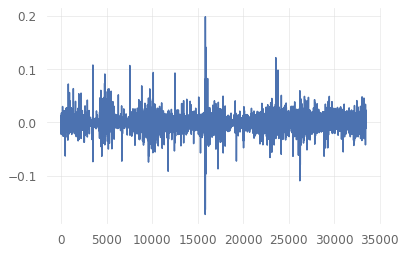

True

In [12]:
import matplotlib.pyplot as plt
plt.plot(get_returns(data, column='close'))
plt.show()
is_data_predictible(data, 'close')

## Percentage of the dataset generating rewards (keep between 5% to 15% or just rely on is_data_predictible())

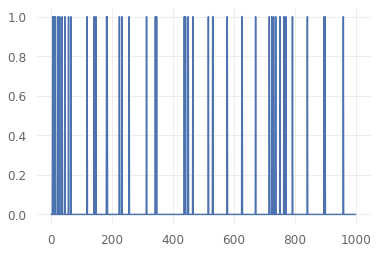

8.2%


In [13]:
plt.plot(precalculate_ground_truths(data, column='close').iloc[:1000])
plt.show()
percent_rewardable = str(round(100 + precalculate_ground_truths(data, column='close').value_counts().pct_change().iloc[-1] * 100, 2)) + '%'
print(percent_rewardable)

## Threshold to pass to AnomalousProfit reward scheme

In [14]:
X_train_test = pd.concat([X_train, X_test], axis='index')
#threshold = estimate_percent_gains(X_train_test, 'close')
threshold = estimate_percent_gains(X_train, 'close')
threshold

0.007113925627856066

## Implement basic feature engineering

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

from feature_engine.selection import SelectBySingleFeaturePerformance

In [16]:
rf = RandomForestClassifier(n_estimators=100, 
                            random_state=seed, 
                            n_jobs=6)

sel = SelectBySingleFeaturePerformance(variables=None, 
                                       estimator=rf, 
                                       scoring="roc_auc", 
                                       cv=5, 
                                       threshold=0.65)

sel.fit(X_train, precalculate_ground_truths(X_train, column='close'))

SelectBySingleFeaturePerformance(cv=5,
                                 estimator=RandomForestClassifier(n_jobs=6,
                                                                  random_state=1337),
                                 threshold=0.65)

In [17]:
feature_performance = pd.Series(sel.feature_performance_).sort_values(ascending=False)
feature_performance

lr_close                   1.000000
others_dr                  1.000000
r_volume                   0.944268
lr_high                    0.837704
volume_vpt                 0.785492
                             ...   
trend_psar_down            0.343790
trend_visual_ichimoku_b    0.343207
trend_ichimoku_b           0.327315
volatility_dch             0.325795
volatility_dcl             0.318098
Length: 140, dtype: float64

Text(0, 0.5, 'roc-auc')

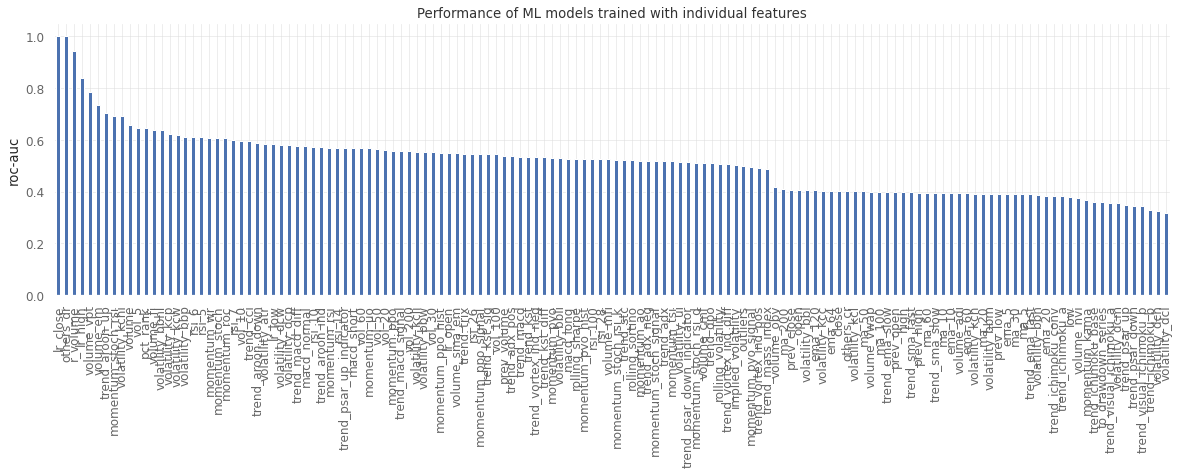

In [18]:
feature_performance.plot.bar(figsize=(20, 5))
plt.title('Performance of ML models trained with individual features')
plt.ylabel('roc-auc')

In [19]:
features_to_drop = sel.features_to_drop_
features_to_drop

['open',
 'high',
 'low',
 'close',
 'volume_adi',
 'volume_obv',
 'volume_cmf',
 'volume_fi',
 'volume_sma_em',
 'volume_vwap',
 'volume_mfi',
 'volume_nvi',
 'volatility_bbm',
 'volatility_bbh',
 'volatility_bbl',
 'volatility_bbw',
 'volatility_bbp',
 'volatility_bbhi',
 'volatility_bbli',
 'volatility_kcc',
 'volatility_kch',
 'volatility_kcl',
 'volatility_kcw',
 'volatility_kcp',
 'volatility_kcli',
 'volatility_dcl',
 'volatility_dch',
 'volatility_dcm',
 'volatility_dcw',
 'volatility_dcp',
 'volatility_atr',
 'volatility_ui',
 'trend_macd',
 'trend_macd_signal',
 'trend_macd_diff',
 'trend_sma_fast',
 'trend_sma_slow',
 'trend_ema_fast',
 'trend_ema_slow',
 'trend_vortex_ind_pos',
 'trend_vortex_ind_neg',
 'trend_vortex_ind_diff',
 'trend_trix',
 'trend_mass_index',
 'trend_dpo',
 'trend_kst',
 'trend_kst_sig',
 'trend_kst_diff',
 'trend_ichimoku_conv',
 'trend_ichimoku_base',
 'trend_ichimoku_a',
 'trend_ichimoku_b',
 'trend_stc',
 'trend_adx',
 'trend_adx_pos',
 'trend_adx_n

In [20]:
to_drop = list(set(features_to_drop) - set(['open', 'high', 'low', 'close', 'volume']))
len(to_drop)

126

In [21]:
X_train = X_train.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)
X_valid = X_valid.drop(columns=to_drop)

X_train.shape, X_test.shape, X_valid.shape

((11201, 15), (11202, 15), (11035, 15))

In [22]:
X_train.columns.tolist()

['date',
 'open',
 'high',
 'low',
 'close',
 'volume',
 'volume_em',
 'volume_vpt',
 'volatility_kchi',
 'trend_aroon_up',
 'momentum_stoch_rsi',
 'others_dr',
 'lr_high',
 'lr_close',
 'r_volume']

## Normalize the dataset subsets to make the model converge faster

In [23]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

scaler_type = MinMaxScaler

def get_feature_scalers(X, scaler_type=scaler_type):
    scalers = []
    for name in list(X.columns[X.columns != 'date']):
        scalers.append(scaler_type().fit(X[name].values.reshape(-1, 1)))
    return scalers

def get_scaler_transforms(X, scalers):
    X_scaled = []
    for name, scaler in zip(list(X.columns[X.columns != 'date']), scalers):
        X_scaled.append(scaler.transform(X[name].values.reshape(-1, 1)))
    X_scaled = pd.concat([pd.DataFrame(column, columns=[name]) for name, column in \
                          zip(list(X.columns[X.columns != 'date']), X_scaled)], axis='columns')
    return X_scaled

def normalize_data(X_train, X_test, X_valid):
    X_train_test = pd.concat([X_train, X_test], axis='index')
    X_train_test_valid = pd.concat([X_train_test, X_valid], axis='index')

    X_train_test_dates = X_train_test[['date']]
    X_train_test_valid_dates = X_train_test_valid[['date']]

    X_train_test = X_train_test.drop(columns=['date'])
    X_train_test_valid = X_train_test_valid.drop(columns=['date'])

    train_test_scalers = \
        get_feature_scalers(X_train_test, 
                            scaler_type=scaler_type)
    train_test_valid_scalers = \
        get_feature_scalers(X_train_test_valid, 
                            scaler_type=scaler_type)

    X_train_test_scaled = \
        get_scaler_transforms(X_train_test, 
                              train_test_scalers)
    X_train_test_valid_scaled = \
        get_scaler_transforms(X_train_test_valid, 
                              train_test_scalers)
    X_train_test_valid_scaled_leaking = \
        get_scaler_transforms(X_train_test_valid, 
                              train_test_valid_scalers)

    X_train_test_scaled = \
        pd.concat([X_train_test_dates, 
                   X_train_test_scaled], 
                  axis='columns')
    X_train_test_valid_scaled = \
        pd.concat([X_train_test_valid_dates, 
                   X_train_test_valid_scaled], 
                  axis='columns')
    X_train_test_valid_scaled_leaking = \
        pd.concat([X_train_test_valid_dates, 
                   X_train_test_valid_scaled_leaking], 
                  axis='columns')

    X_train_scaled = X_train_test_scaled.iloc[:X_train.shape[0]]
    X_test_scaled = X_train_test_scaled.iloc[X_train.shape[0]:]
    X_valid_scaled = X_train_test_valid_scaled.iloc[X_train_test.shape[0]:]
    X_valid_scaled_leaking = X_train_test_valid_scaled_leaking.iloc[X_train_test.shape[0]:]

    return (train_test_scalers, 
            train_test_valid_scalers, 
            X_train_scaled, 
            X_test_scaled, 
            X_valid_scaled, 
            X_valid_scaled_leaking)

In [24]:
train_test_scalers, train_test_valid_scalers, X_train_scaled, X_test_scaled, X_valid_scaled, X_valid_scaled_leaking = \
    normalize_data(X_train, X_test, X_valid)

## Save new feature set

In [25]:
import os
cwd = os.getcwd()

train_csv = os.path.join(cwd, 'train.csv')
test_csv = os.path.join(cwd, 'test.csv')
valid_csv = os.path.join(cwd, 'valid.csv')
train_scaled_csv = os.path.join(cwd, 'train_scaled.csv')
test_scaled_csv = os.path.join(cwd, 'test_scaled.csv')
valid_scaled_csv = os.path.join(cwd, 'valid_scaled.csv')
valid_scaled_leaking_csv = os.path.join(cwd, 'valid_scaled_leaking.csv')

X_train.to_csv(train_csv, index=False)
X_test.to_csv(test_csv, index=False)
X_valid.to_csv(valid_csv, index=False)
X_train.to_csv(train_scaled_csv, index=False)
X_test.to_csv(test_scaled_csv, index=False)
X_valid.to_csv(valid_scaled_csv, index=False)
X_valid.to_csv(valid_scaled_leaking_csv, index=False)

## Write a renderer

In [26]:
# Things to understand here:
# Writing a Renderer

import matplotlib.pyplot as plt

from tensortrade.env.generic import Renderer


class PositionChangeChart(Renderer):
    def __init__(self, color: str = "orange"):
        self.color = "orange"

    def render(self, env, **kwargs):
        history = pd.DataFrame(env.observer.renderer_history)

        actions = list(history.action)
        price = list(history.close)

        buy = {}
        sell = {}

        for i in range(len(actions) - 1):
            a1 = actions[i]
            a2 = actions[i + 1]

            if a1 != a2:
                if a1 == 0 and a2 == 1:
                    buy[i] = price[i]
                else:
                    sell[i] = price[i]

        buy = pd.Series(buy)
        sell = pd.Series(sell)

        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        fig.suptitle("Performance")

        axs[0].plot(np.arange(len(price)), price, label="price", color=self.color)
        axs[0].scatter(buy.index, buy.values, marker="^", color="green")
        axs[0].scatter(sell.index, sell.values, marker="^", color="red")
        axs[0].set_title("Trading Chart")

        performance_df = pd.DataFrame().from_dict(env.action_scheme.portfolio.performance, orient='index')
        performance_df.plot(ax=axs[1])
        axs[1].set_title("Net Worth")

        plt.show()

## Write a reward scheme encouraging rare volatile upside trades

In [27]:
from tensortrade.env.default.rewards import TensorTradeRewardScheme


class AnomalousProfit(TensorTradeRewardScheme):
    """A simple reward scheme that rewards the agent for exceeding a 
    precalculated percentage in the net worth.

    Parameters
    ----------
    threshold : float
        The minimum value to exceed in order to get the reward.

    Attributes
    ----------
    threshold : float
        The minimum value to exceed in order to get the reward.
    """

    registered_name = "anomalous"

    def __init__(self, threshold: float = 0.02, window_size: int = 1):
        self._window_size = self.default('window_size', window_size)
        self._threshold = self.default('threshold', threshold)

    def get_reward(self, portfolio: 'Portfolio') -> float:
        """Rewards the agent for incremental increases in net worth over a
        sliding window.

        Parameters
        ----------
        portfolio : `Portfolio`
            The portfolio being used by the environment.

        Returns
        -------
        int
            Whether the last percent change in net worth exceeds the predefined 
            `threshold`.
        """
        performance = pd.DataFrame.from_dict(portfolio.performance).T
        current_step = performance.shape[0]
        if current_step > 1:
            # Hint: make it cumulative.
            net_worths = performance['net_worth']
            ground_truths = precalculate_ground_truths(performance, 
                                                       column='net_worth', 
                                                       threshold=self._threshold)
            reward_factor = 2.0 * ground_truths - 1.0
            #return net_worths.iloc[-1] / net_worths.iloc[-min(current_step, self._window_size + 1)] - 1.0
            return (reward_factor * net_worths.abs()).iloc[-1]

        else:
            return 0.0

In [28]:
class PenalizedProfit(TensorTradeRewardScheme):
    """A reward scheme which penalizes net worth loss and 
    decays with the time spent.

    Parameters
    ----------
    cash_penalty_proportion : float
        cash_penalty_proportion

    Attributes
    ----------
    cash_penalty_proportion : float
        cash_penalty_proportion.
    """

    registered_name = "penalized"

    def __init__(self, cash_penalty_proportion: float = 0.10):
        self._cash_penalty_proportion = \
            self.default('cash_penalty_proportion', 
                         cash_penalty_proportion)

    def get_reward(self, portfolio: 'Portfolio') -> float:
        """Rewards the agent for gaining net worth while holding the asset.

        Parameters
        ----------
        portfolio : `Portfolio`
            The portfolio being used by the environment.

        Returns
        -------
        int
            A penalized reward.
        """
        performance = pd.DataFrame.from_dict(portfolio.performance).T
        current_step = performance.shape[0]
        if current_step > 1:
            initial_amount = portfolio.initial_net_worth
            net_worth = performance['net_worth'].iloc[-1]
            cash_worth = performance['bitstamp:/USD:/total'].iloc[-1]
            cash_penalty = max(0, (net_worth * self._cash_penalty_proportion - cash_worth))
            net_worth -= cash_penalty
            reward = (net_worth / initial_amount) - 1
            reward /= current_step
            return reward
        else:
            return 0.0

## Setup Trading Environment

In [29]:
import tensortrade.env.default as default

from tensortrade.feed.core import DataFeed, Stream
from tensortrade.feed.core.base import NameSpace
from tensortrade.env.default.actions import BSH
from tensortrade.env.default.rewards import PBR, RiskAdjustedReturns, SimpleProfit
from tensortrade.oms.exchanges import Exchange, ExchangeOptions
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.instruments import USD, BTC, ETH
from tensortrade.oms.wallets import Wallet, Portfolio
from tensortrade.oms.orders import TradeType

# TODO: adjust according to your commission percentage, if present
commission = 0.01
price = Stream.source(list(X_train["close"]), 
                      dtype="float").rename("USD-BTC")
bitstamp_options = ExchangeOptions(commission=commission)
bitstamp = Exchange("bitstamp", 
                    service=execute_order, 
                    options=bitstamp_options)(price)

cash = Wallet(bitstamp, 10000 * USD)
asset = Wallet(bitstamp, 0 * BTC)

portfolio = Portfolio(USD, [cash, asset])

with NameSpace("bitstamp"):
    features = [
        Stream.source(list(X_train_scaled[c]), 
                      dtype="float").rename(c) for c in X_train_scaled.columns[1:]
        #Stream.source(list(X_train_scaled['lr_close']), dtype="float").rename('lr_close')
    ]

feed = DataFeed(features)
feed.compile()

reward_scheme = PBR(price=price)

#reward_scheme = RiskAdjustedReturns(return_algorithm='sortino',
#                                    window_size=15)

#reward_scheme = SimpleProfit(window_size=30)

#reward_scheme = AnomalousProfit(threshold=threshold)

#reward_scheme = PenalizedProfit(cash_penalty_proportion=0.1)

#action_scheme = BSH(
#    cash=cash,
#    asset=asset
#)

action_scheme = BSH(
    cash=cash,
    asset=asset
).attach(reward_scheme)

renderer_feed = DataFeed([
    Stream.source(list(X_train["date"])).rename("date"),
    Stream.source(list(X_train["open"]), dtype="float").rename("open"),
    Stream.source(list(X_train["high"]), dtype="float").rename("high"),
    Stream.source(list(X_train["low"]), dtype="float").rename("low"),
    Stream.source(list(X_train["close"]), dtype="float").rename("close"), 
    Stream.source(list(X_train["volume"]), dtype="float").rename("volume"), 
        Stream.sensor(action_scheme, 
                      lambda s: s.action, dtype="float").rename("action")
])

renderer = [
    PositionChangeChart(),
    default.renderers.PlotlyTradingChart(),
]

max_allowed_loss = 0.90
min_periods = window_size  # Minimum of window_size

observer = default.observers.TensorTradeObserver(
    portfolio=portfolio,
    feed=feed,
    renderer_feed=renderer_feed,
    window_size=window_size,
    min_periods=min_periods
)

stopper = default.stoppers.MaxLossStopper(
    max_allowed_loss=max_allowed_loss
)

informer = default.informers.TensorTradeInformer()

random_start_pct = 0.0

env = default.create(
    portfolio=portfolio,
    action_scheme=action_scheme,
    reward_scheme=reward_scheme,
    feed=feed,
    renderer_feed=renderer_feed,
    renderer=renderer,
    observer=observer,
    stopper=stopper,
    informer=informer,
    min_periods=min_periods,
    random_start_pct=random_start_pct,
    window_size=30
)

In [30]:
env.observer.feed.next()

{'internal': {'bitstamp:/USD-BTC': 7538.28,
  'bitstamp:/USD:/free': 10000.0,
  'bitstamp:/USD:/locked': 0.0,
  'bitstamp:/USD:/total': 10000.0,
  'bitstamp:/BTC:/free': 0.0,
  'bitstamp:/BTC:/locked': 0.0,
  'bitstamp:/BTC:/total': 0.0,
  'bitstamp:/BTC:/worth': 0.0,
  'net_worth': 10000.0},
 'external': {'bitstamp:/open': 0.26233513696313826,
  'bitstamp:/high': 0.2589494221642358,
  'bitstamp:/low': 0.2618512299271504,
  'bitstamp:/close': 0.26023362848962917,
  'bitstamp:/volume': 0.03894471016987649,
  'bitstamp:/volume_em': 0.0028271190913507485,
  'bitstamp:/volume_vpt': 0.5420696935378952,
  'bitstamp:/volatility_kchi': 0.0,
  'bitstamp:/trend_aroon_up': 0.3333333333333333,
  'bitstamp:/momentum_stoch_rsi': 0.8630517795451335,
  'bitstamp:/others_dr': 0.45254029202278684,
  'bitstamp:/lr_high': 0.45170100819463627,
  'bitstamp:/lr_close': 0.4987730902226224,
  'bitstamp:/r_volume': 0.5744556657092559},
 'renderer': {'date': '2018-05-24 08:00 PM',
  'open': 7573.86,
  'high': 75

## Setup and Train an Agent

In [45]:
def get_optimal_batch_size(window_size=30, n_steps=1000, batch_factor=4, stride=1):
    """
    lookback = 30          # Days of past data (also named window_size).
    batch_factor = 4       # batch_size = (sample_size - lookback - stride) // batch_factor
    stride = 1             # Time series shift into the future.
    """
    lookback = window_size
    sample_size = n_steps
    batch_size = ((sample_size - lookback - stride) // batch_factor)
    return batch_size

batch_size = get_optimal_batch_size(window_size=window_size, n_steps=n_steps, batch_factor=4)
batch_size

242

In [46]:
def evaluate(model, 
             env=None, 
             n_eval_episodes=1, 
             n_eval_steps=100, 
             render_episode_count=1, 
             render_step_count=10, 
             render_episodes=False, 
             render_steps=True):
    """
    Evaluate a RL agent, with rendering
    :param model: (BaseRLModel object) the RL Agent
    :param n_eval_episodes: (int) number of episodes to evaluate it
    :return: (float) Mean reward for the last n_eval_episodes
    """
    if env is None:
        env = model.get_env()

    render_episode_interval = n_eval_episodes // render_episode_count
    render_step_interval = n_eval_steps // render_step_count

    all_episode_rewards = []
    for i in range(n_eval_episodes):
        episode_rewards = []
        done = False
        obs = env.reset()
        if n_eval_steps < 1:
            while not done:
                # _states are only useful when using LSTM policies
                action, _states = model.predict(obs, deterministic=True)
                # here, action, rewards and dones are arrays
                # because we are using vectorized env
                obs, reward, done, info = env.step(action)
                episode_rewards.append(reward)
                if render_steps and (i % render_step_interval) == 0:
                    env.render()
        else:
            for i in range(n_eval_steps):
                # _states are only useful when using LSTM policies
                action, _states = model.predict(obs, deterministic=True)
                # here, action, rewards and dones are arrays
                # because we are using vectorized env
                obs, reward, done, info = env.step(action)
                episode_rewards.append(reward)
                if render_steps and (i % render_step_interval) == 0:
                    env.render()

        all_episode_rewards.append(sum(episode_rewards))

        if render_episodes and (i % render_episode_interval) == 0:
            env.render()

        if done:
            obs = env.reset()

    mean_episode_reward = np.mean(all_episode_rewards)
    std_episode_reward = np.std(all_episode_rewards)
    
    print(f"Reward mean: {mean_reward:.2f} +/- {std_reward:.2f} "
          f"standard deviation for {n_eval_episodes:.2f} episodes")

    return std_episode_reward, mean_episode_reward

In [47]:
%load_ext tensorboard

In [48]:
%tensorboard --bind_all --logdir logs

In [49]:
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.logger import configure
from stable_baselines3 import PPO

new_logger = configure('logs', ['stdout', 'csv', 'tensorboard'])  # Setup logger

env = Monitor(env)

model = PPO('MlpPolicy', env, verbose=1)
model.set_logger(new_logger)  # Set new logger

Logging to logs
Using cuda device
Wrapping the env in a DummyVecEnv.


In [50]:
# Random Agent, before training
from stable_baselines3.common.evaluation import evaluate_policy

#mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=1)

#print(f"mean_reward: {mean_reward:.2f} +/- {std_reward:.2f}")

## TODO: implement tuning

## Agent training

In [51]:
# Train the agent
model.learn(total_timesteps=10000)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 452      |
|    ep_rew_mean     | -34.1    |
| time/              |          |
|    fps             | 382      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 465         |
|    ep_rew_mean          | 255         |
| time/                   |             |
|    fps                  | 300         |
|    iterations           | 2           |
|    time_elapsed         | 13          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012748137 |
|    clip_fraction        | 0.041       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.684      |
|    explained_variance   | -1.61e-05   |
|    learning_rate        | 0.

In [52]:
model.save("tradingenv_training")

## Implement validation

In [53]:
#mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=1)

#print(f"mean_reward: {mean_reward:.2f} +/- {std_reward:.2f}")

In [57]:
steps = 10000
render_interval = steps // 10
obs = env.reset()
for i in range(steps):
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.env.step(action)
#    if (i % render_interval) == 0:
#        env.render()
#    if done:
#        obs = env.reset()

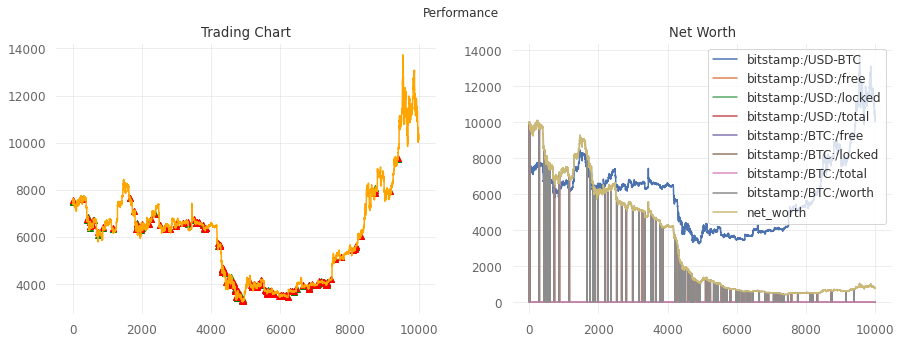

FigureWidget({
    'data': [{'close': array([7538.28, 7515.  , 7574.71, ..., 6634.8 , 6617.6 , 6634.8 ]),
    …

In [58]:
env.env.render()